In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mofax as mfx
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import metrics
from collections import Counter

In [2]:
# define models
m_coad = mfx.mofa_model('Trained_models/test_model_coad_4_omics_fpkm.hdf5')
m_coad_metastasis = mfx.mofa_model('Trained_models/test_model_coad_4_omics_fpkm_metastasis.hdf5')
m_read = mfx.mofa_model('Trained_models/test_model_coad_4_omics.hdf5')
m_read_metastasis = mfx.mofa_model('Trained_models/test_model_read_4_omics_fpkm_metastasis.hdf5')
m_coad_3 = mfx.mofa_model('Trained_models/test_model_coad.hdf5')
m_coad_2_percent = mfx.mofa_model('Trained_models/model_coad_4_omics_fpkm_2_percent_r_square.hdf5')

In [3]:
# read the group files which are later used as clinical data for the cox regression
coad_clinical = pd.read_csv('mofa_coad_groups.tsv', sep='\t', index_col=0)
read_clinical = pd.read_csv('mofa_read_groups.tsv', sep='\t', index_col=0)
all_clinical = pd.concat([coad_clinical, read_clinical], axis=0)

/home/g48r1el/.pyenv/versions/3.13.3/lib/python3.13/site-packages/mofax/plot_weights.py:134: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna({"to_label": False})


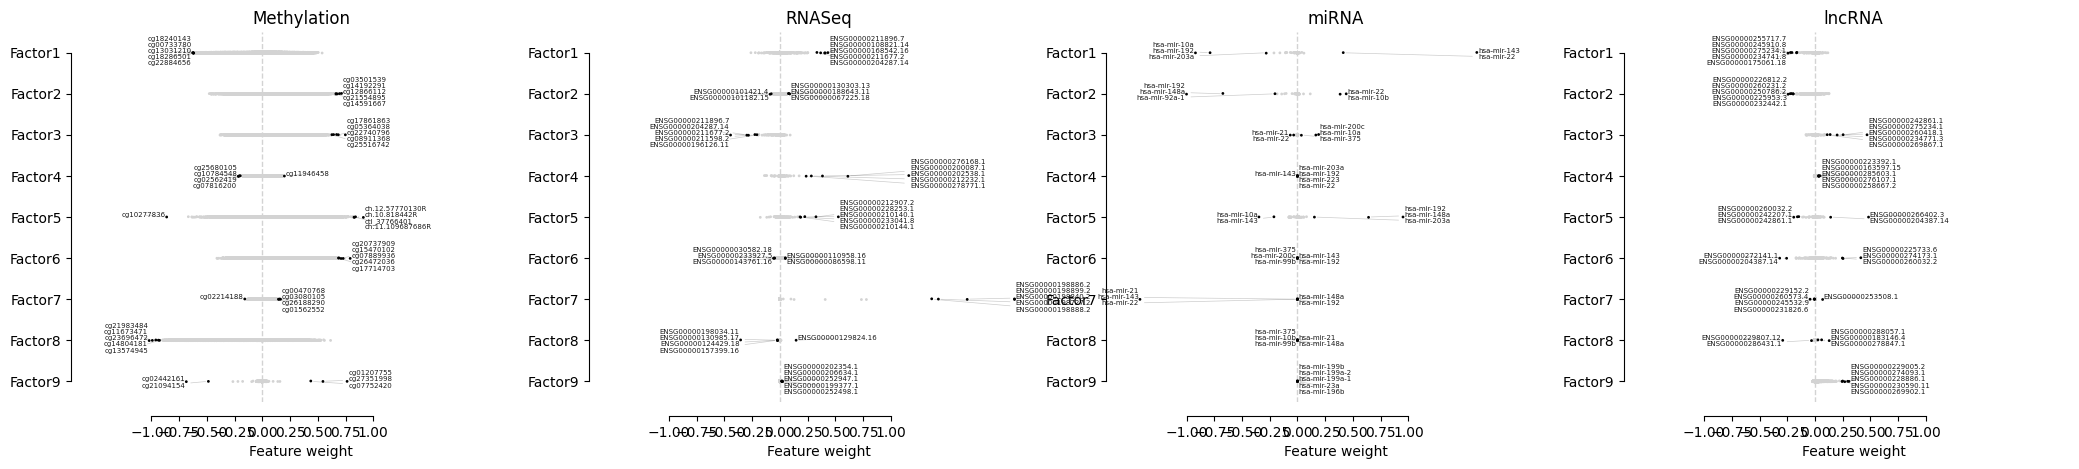

In [4]:
# plot the weights
ax = mfx.plot_weights(m_coad)

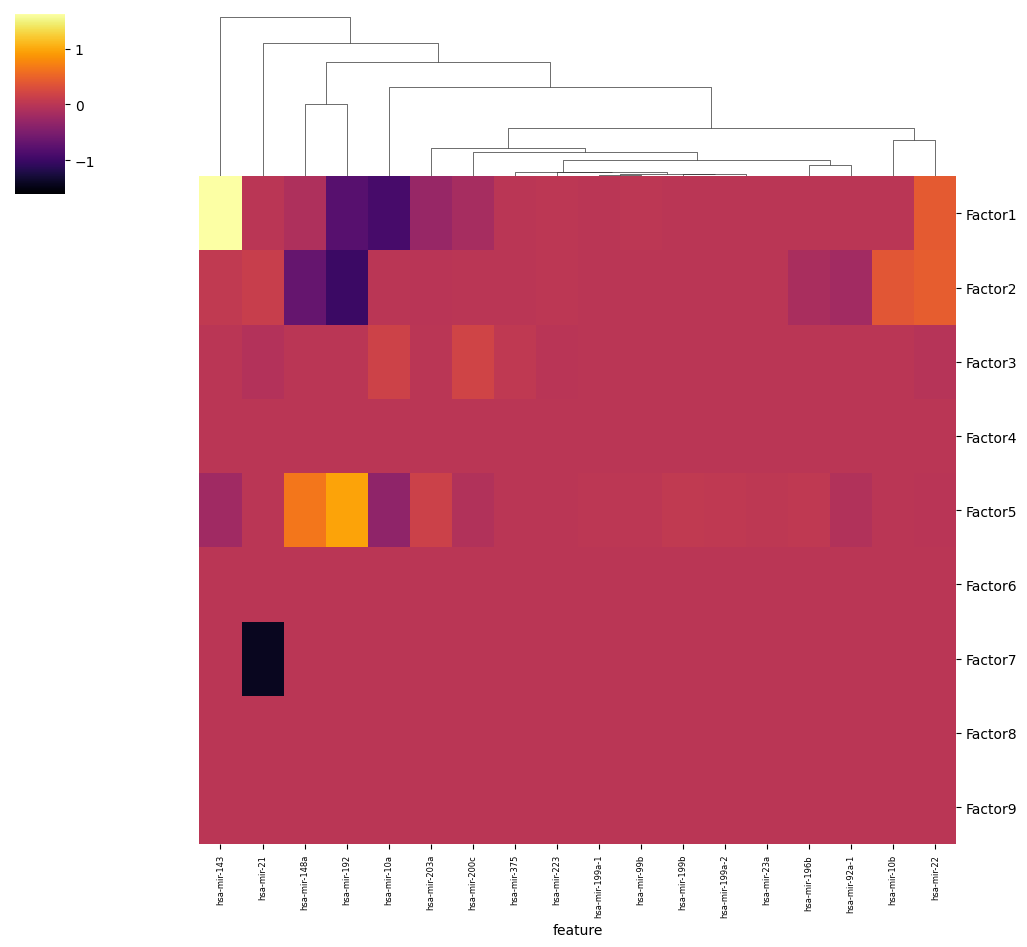

In [16]:
# plot heatmap of the model
mfx.plot_weights_heatmap(m_coad, n_features=5, 
                         factors=range(0, 9), 
                         xticklabels_size=6, w_abs=False, 
                         cmap="inferno", cluster_factors=False, vmin=-1.6)
plt.savefig(f'Jupyter_outputs/Heatmaps/coad_mirna_with_negative.png', bbox_inches='tight')

lncRNA


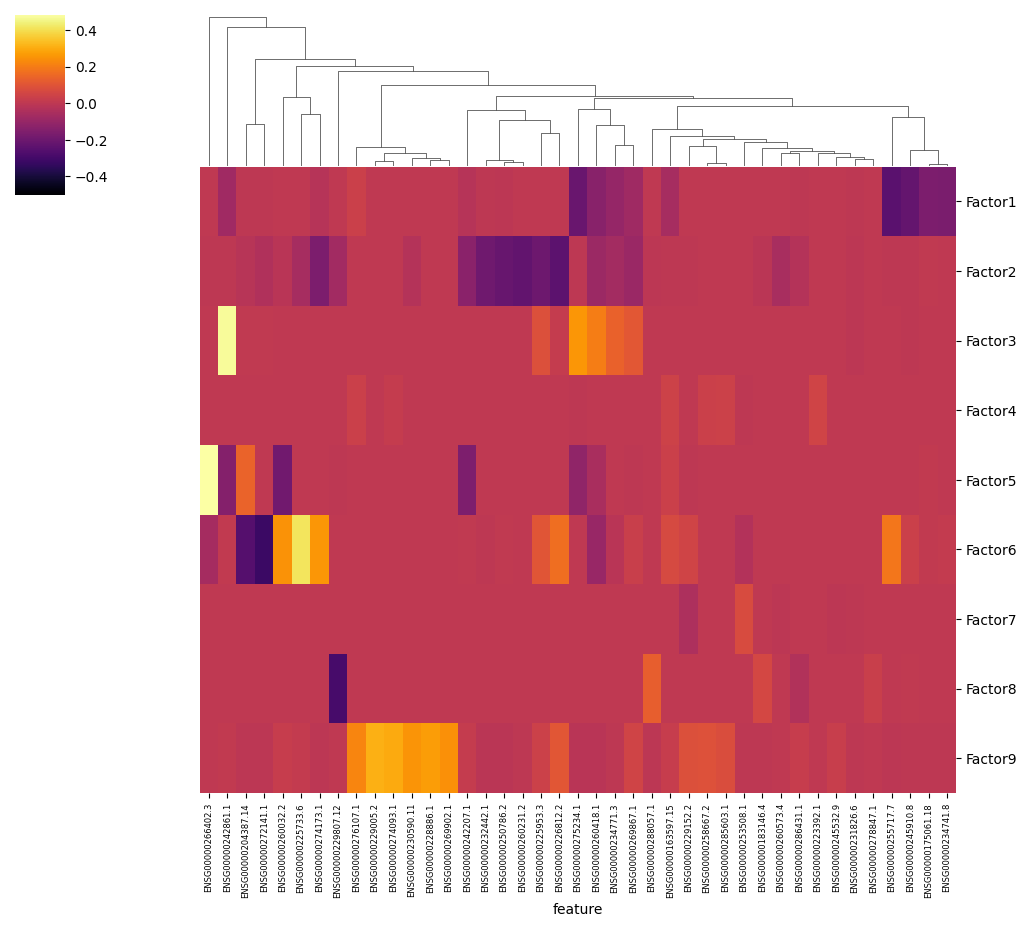

In [17]:
# plot heatmap of the model
print('lncRNA')
mfx.plot_weights_heatmap(m_coad, n_features=5, 
                         factors=range(0, 9), view=1,
                         xticklabels_size=6, w_abs=False, 
                         cmap="inferno", cluster_factors=False, vmin=-0.5)
plt.savefig(f'Jupyter_outputs/Heatmaps/coad_lncrna_with_negative.png', bbox_inches='tight')

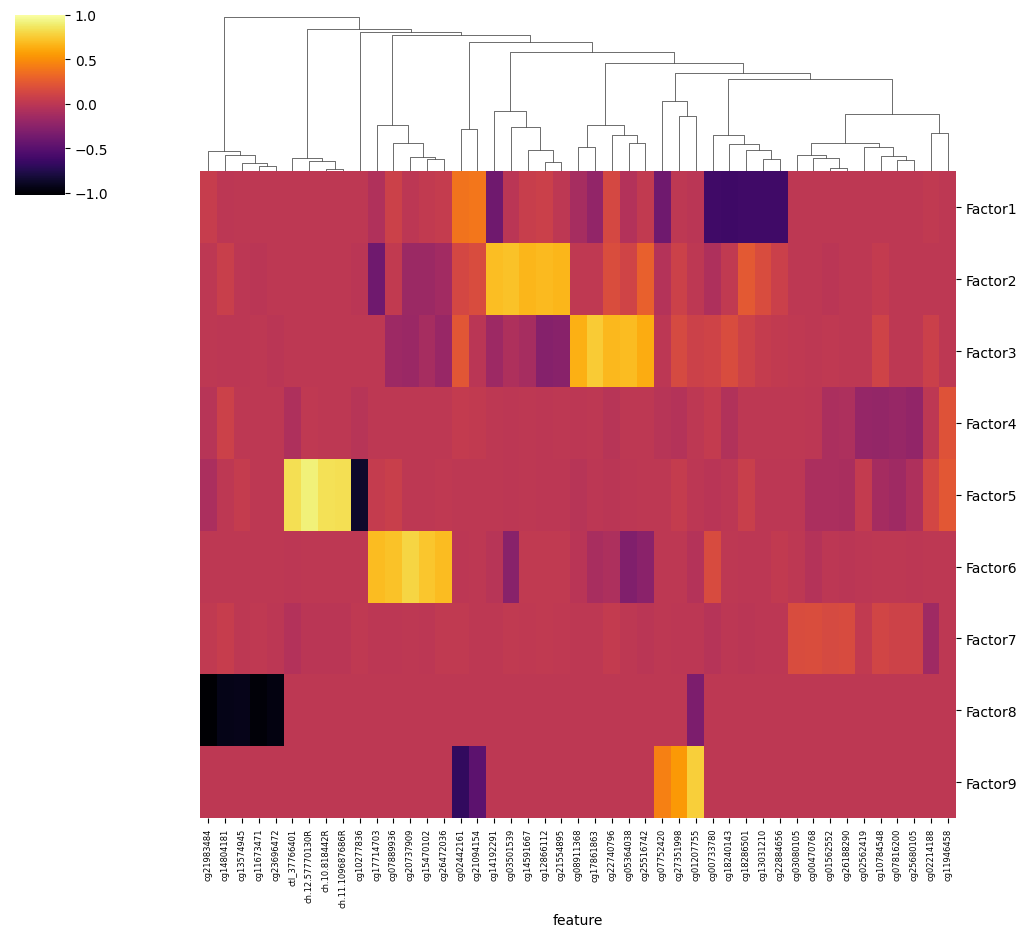

In [18]:
mfx.plot_weights_heatmap(m_coad, n_features=5, 
                         factors=range(0, 9), view=2,
                         xticklabels_size=6, w_abs=False, 
                         cmap="inferno", cluster_factors=False, vmax=1)
plt.savefig(f'Jupyter_outputs/Heatmaps/coad_dna_methylation_with_negative.png', bbox_inches='tight')

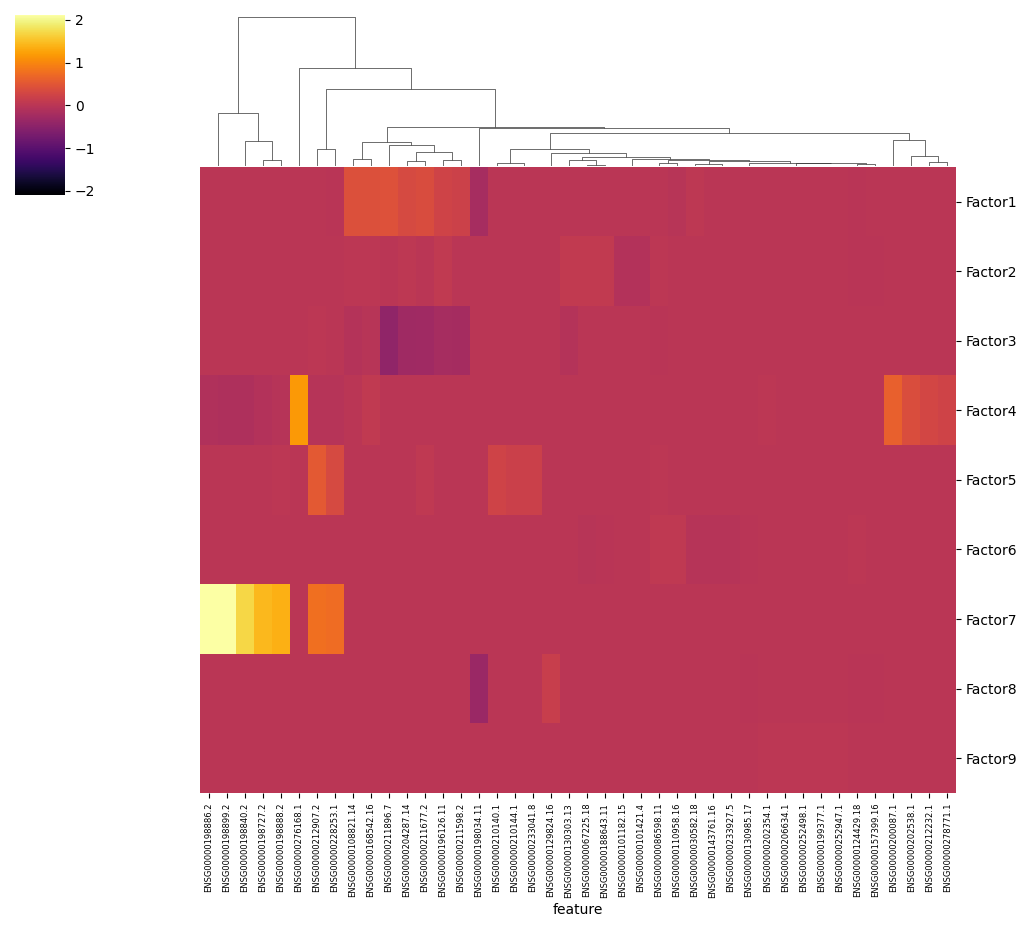

In [19]:
mfx.plot_weights_heatmap(m_coad, n_features=5, 
                         factors=range(0, 9), view=3,
                         xticklabels_size=6, w_abs=False, vmin=-2.1,
                         cmap="inferno", cluster_factors=False)
plt.savefig(f'Jupyter_outputs/Heatmaps/coad_rnaseq.png', bbox_inches='tight')

In [ ]:
"""
for i in range(9):
    ax = mfx.plot_weights_ranked(m, factor=i, n_features=10,
                            y_repel_coef=0.04, x_rank_offset=-150)
    ax.plot()
    plt.savefig(f'mirna_weights_ranked_factor_{i}.png')
    ax.clear()
"""

In [ ]:
"""
for i in range(9):
    ax = mfx.plot_weights_ranked(m, factor=i, n_features=10, view=1,
                            y_repel_coef=0.04, x_rank_offset=-150)
    ax.plot()
    plt.savefig(f'lncrna_weights_ranked_factor_{i}.png')
    ax.clear()
"""

In [ ]:
"""
for i in range(9):
    ax = mfx.plot_weights_ranked(m, factor=i, n_features=10, view=2,
                            y_repel_coef=0.04, x_rank_offset=-150)
    ax.plot()
    plt.savefig(f'dna_methylation_weights_ranked_factor_{i}.png')
    ax.clear()
"""

In [ ]:
fig = mfx.plot_r2(m_coad_2_percent, factors=list(range(10)), cmap="Blues")
fig.savefig('Jupyter_outputs/coad_2_percent_variance_explained.png', bbox_inches='tight')
mfx.plot_r2(m_coad_2_percent, factors=list(range(10)), cmap="Blues")

In [ ]:
# cox regression with factor values
def cox_regression(m, clinical_data, cancer_type):
    cox_factors = pd.DataFrame(m.get_factors(), index=m.get_samples()['sample'].values)
    cox_df = cox_factors.join(clinical_data.loc[:, ['survival_time', 'vital_status']])
    cox_df = cox_df.fillna(value=0)
    cph = CoxPHFitter(l1_ratio=0.5)
    print(cox_df['vital_status'].value_counts())
    cph.fit(cox_df, duration_col='survival_time', event_col='vital_status', show_progress=True)
    cph.plot()
    plt.savefig(f'Jupyter_outputs/cox_regression/{cancer_type}_cox_regression_4_omics.png')
    cph.summary.sort_values('coef', ascending=False).to_csv(f'Jupyter_outputs/cox_regression/{cancer_type}_cox_coefficients.csv')
    cph.summary.sort_values('coef', ascending=False)

In [ ]:
# kaplan-meier curve
def draw_km_curve(km_clinical, cancer_type):
    kmf = KaplanMeierFitter()
    time = km_clinical['survival_time']
    status = km_clinical['vital_status'].fillna(0)
    kmf.fit(time, status)
    kmf.plot()
    plt.savefig(f'Jupyter_outputs/km_curves/km_curve_{cancer_type}.png')

In [ ]:
# k-means clustering process
def k_means_clustering(m):
    cancer_factors = pd.DataFrame(m.get_factors(), index=m.get_samples()['sample'].values)
    silhouette_scores = []
    silhouette_sample_scores = []
    clustering_objects = {}
    for i in range(2, 21):
        clustering = KMeans(n_clusters = i, n_init = 10)
        clustering = clustering.fit(cancer_factors)
        silhouette_scores.append(metrics.silhouette_score(cancer_factors, clustering.labels_))
        silhouette_sample_scores.append(metrics.silhouette_samples(cancer_factors, clustering.labels_))
        clustering_objects[i] = clustering
    return clustering_objects, silhouette_scores, silhouette_sample_scores

In [ ]:
# plot the silhouette scores
def plot_silhouette_scores(clustering_result, n, outfile_prefix):
    plt.close()
    # Create the constraints of the plot
    y_lower = 0
    fig, ax = plt.subplots()
    ax.set_xlim([-0.2, 1])
    ax.set_ylim([0, len(clustering_result[0][n].labels_) + (n + 1) * 10])
    # aggregate the silhouette scores of the clusters
    for i in range(n):
        ith_cluster_silhouette_values = clustering_result[2][n - 2][clustering_result[0][n].labels_ == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        # fill the plot with the cluster
        color = cm.inferno(float(i) / (n - 1))
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax.set_title(f"The silhouette plot for the {n} clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    fig.set_figheight(8)
    plt.savefig(f'Jupyter_outputs/Silhouette_scores/{outfile_prefix}_{n}_clusters_silhouette_score.png')
    plt.show()

In [ ]:
cox_regression(m_coad_metastasis, coad_clinical, 'coad_metastasis')

In [ ]:
draw_km_curve(coad_clinical, 'coad_metastasis')

In [ ]:
coad_metastasis_k_means_clusters = k_means_clustering(m_coad_metastasis)
coad_k_means_clusters = k_means_clustering(m_coad)
coad_3_k_means_clusters = k_means_clustering(m_coad_3)
coad_2_percent_k_means_clusters = k_means_clustering(m_coad_2_percent)

In [ ]:
for n in range(2, len(coad_2_percent_k_means_clusters[0]) + 1):
    plot_silhouette_scores(coad_2_percent_k_means_clusters, n, 'coad_2_percent_k_means')

In [ ]:
# visualize the clusters on a 2-dimensional plot, where the x- and y-axis correspond to one factor
def visualize_clusters(m, x, y, n_clusters, directory, lt = -float('inf'), ut = float('inf')):
    factors = pd.DataFrame(m.get_factors(), index=m.get_samples()['sample'].values)
    factors.index = range(len(factors))
    factors = factors.loc[(factors[x] > lt) & (factors[x] < ut) & (factors[y] > lt) & (factors[y] < ut), :]
    plt.close()
    scatter = plt.scatter(factors[x], factors[y], c=coad_3_k_means_clusters[0][n_clusters].labels_[factors.index], cmap='inferno')
    plt.title(f'Scatter plot for factors {x+1} and {y+1} of {n_clusters} Clusters')
    plt.xlabel(f'Factor {x+1}')
    plt.ylabel(f'Factor {y+1}')
    plt.legend(loc='lower right', scatterpoints=1, labels=[f'cluster {j}' for j in range(n_clusters)], handles=scatter.legend_elements()[0])
    plt.savefig(f'Jupyter_outputs/Scatter_Plots/{directory}/coad_2_percent_scatter_factors_{x+1}_and_{y+1}_{n_clusters}_clusters.png')
    plt.show()

In [ ]:
for n in range(2, len(coad_3_k_means_clusters[0]) + 1):
    for i in range(9):
        for j in range(i + 1, 9):
            visualize_clusters(m_coad_2_percent_k_means_clusters, i, j, n, 'coad_3')

- survival clusters
- associciation of pairsẃise log ranks clusters


In [ ]:
def survival_by_clusters(m, clinical_data, n_clusters, cancer_type):
    # draw a KM curve for each cluster
    cox_factors = pd.DataFrame(m.get_factors(), index=m.get_samples()['sample'].values)
    cox_df = cox_factors.join(clinical_data.loc[:, ['survival_time', 'vital_status']])
    cox_df = cox_df.fillna(value=0)
    plt.close()
    clusters = coad_k_means_clusters[0][n_clusters]
    for i in range(n_clusters):
        kmf = KaplanMeierFitter(label=f'Cluster {i}')
        time = cox_df.loc[clusters.labels_ == i, 'survival_time']
        status = cox_df.loc[clusters.labels_ == i, 'vital_status'].fillna(0)
        kmf.fit(time, status)
        kmf.plot(color=cm.inferno(i / (n_clusters - 1)))
    plt.savefig(f'Jupyter_outputs/km_curves/km_curve_{cancer_type}_for_{n_clusters}_clusters.png')

In [ ]:
for n in range(2, 21):
    survival_by_clusters(m_coad, coad_clinical, n, 'coad')

In [ ]:
for n in range(2, 21):
    print(Counter(coad_metastasis_k_means_clusters[0][n].labels_))

In [ ]:
# m1.close() 

In [ ]:
# cox regression with factor values
def cox_regression_for_clusters(m, n_clusters, clinical_data):
    print(f'Execute for {n_clusters} clusters')
    cox_factors = pd.DataFrame(m.get_factors(), index=m.get_samples()['sample'].values)
    cox_df = cox_factors.join(clinical_data.loc[:, ['survival_time', 'vital_status']])
    cox_df = cox_df.fillna(value=0)
    clusters = coad_k_means_clusters[0][n_clusters]
    log_rank_test_values = {}
    for i in range(n_clusters):
        if sum(clusters.labels_ == i) < 3:
            continue
        plt.close()
        cph = CoxPHFitter(l1_ratio=1)
        log_rank_test_values[i] = cox_df.loc[clusters.labels_ == i, :]
        cph.fit(cox_df.loc[clusters.labels_ == i, :], duration_col='survival_time', event_col='vital_status', show_progress=True)
        cph.plot()
        plt.savefig(f'Jupyter_outputs/cox_regression/cox_regression_4_omics_cluster_{i}_of_{n_clusters}_clusters.png')
        cph.summary.sort_values('coef', ascending=False).to_csv(f'Jupyter_outputs/coad_metastasis_cox_coefficients_cluster_{i}_of_{n_clusters}_cluster.csv')
        print(cph.summary.sort_values('coef', ascending=False))
    # log rank test between the clusters
    for i in log_rank_test_values.keys():
        for j in log_rank_test_values.keys():
            if i < j:
                log_rank_test_result = logrank_test(log_rank_test_values[i]['survival_time'], log_rank_test_values[j]['survival_time'],
                                                    log_rank_test_values[i]['vital_status'], log_rank_test_values[j]['vital_status'])
                print(f'Logrank test between Clusters {i} and {j}: {log_rank_test_result.p_value}')

In [ ]:
cox_regression_for_clusters(m_coad, 3, coad_clinical)
cox_regression_for_clusters(m_coad, 4, coad_clinical)
cox_regression_for_clusters(m_coad, 5, coad_clinical)
cox_regression_for_clusters(m_coad, 6, coad_clinical)

In [ ]:
visualize_clusters(m_coad, 1, 4, 4, -20, 20)

In [ ]:
coad_k_means_clusters[0][4].labels_

In [ ]:
coad_clinical.iloc[np.where(coad_k_means_clusters[0][4].labels_ == 2)].metastasis.value_counts()

In [ ]:
m_coad.close()
m_coad_metastasis.close()
m_read.close()
m_read_metastasis.close()
m_both.close()
m_both_metastasis.close()
m_coad_3.close()

In [ ]:
mirna_data = pd.read_csv('mofa_mirna.tsv', sep='\t', index_col=0)
mir_192 = mirna_data.loc['hsa-mir-192', :]
mir_192_lower = mir_192.loc[mir_192 < mir_192.quantile(0.5)]
mir_192_upper = mir_192.loc[mir_192 >= mir_192.quantile(0.5)]
coad_clinical.loc[[*{*coad_clinical.index} & {*mir_192_lower.index}], :]

In [ ]:
kmf = KaplanMeierFitter(label='mir-192 higher expression')
time = coad_clinical.loc[coad_clinical.loc[[*{*coad_clinical.index} & {*mir_192_upper.index}], :].index, 'survival_time']
status = coad_clinical.loc[coad_clinical.loc[[*{*coad_clinical.index} & {*mir_192_upper.index}], :].index, 'vital_status'].fillna(0)
kmf.fit(time, status)
kmf.plot()
kmf = KaplanMeierFitter(label='mir-192 lower expression')
time = coad_clinical.loc[coad_clinical.loc[[*{*coad_clinical.index} & {*mir_192_lower.index}], :].index, 'survival_time']
status = coad_clinical.loc[coad_clinical.loc[[*{*coad_clinical.index} & {*mir_192_lower.index}], :].index, 'vital_status'].fillna(0)
kmf.fit(time, status)
kmf.plot()

In [ ]:
mir_148 = mirna_data.loc['hsa-mir-148a', :]
mir_148_lower = mir_192.loc[mir_148 < mir_148.quantile(0.5)]
mir_148_upper = mir_192.loc[mir_148 >= mir_148.quantile(0.5)]
coad_clinical.loc[[*{*coad_clinical.index} & {*mir_148_lower.index}], :]

In [ ]:
kmf = KaplanMeierFitter(label='mir-148a higher expression')
time = coad_clinical.loc[coad_clinical.loc[[*{*coad_clinical.index} & {*mir_148_upper.index}], :].index, 'survival_time']
status = coad_clinical.loc[coad_clinical.loc[[*{*coad_clinical.index} & {*mir_148_upper.index}], :].index, 'vital_status'].fillna(0)
kmf.fit(time, status)
kmf.plot()
kmf = KaplanMeierFitter(label='mir-148a lower expression')
time = coad_clinical.loc[coad_clinical.loc[[*{*coad_clinical.index} & {*mir_148_lower.index}], :].index, 'survival_time']
status = coad_clinical.loc[coad_clinical.loc[[*{*coad_clinical.index} & {*mir_148_lower.index}], :].index, 'vital_status'].fillna(0)
kmf.fit(time, status)
kmf.plot()

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('../TCGA_data/GDCdata/TCGA-COAD/Clinical/Clinical_Supplement/b4432c4b-6881-4f1e-a190-d4efdf203179/nationwidechildrens.org_clinical.TCGA-AA-3971.xml')
root = tree.getroot()
[*root.iter()]

In [ ]:
age_2 = coad_clinical.loc[(m_coad.get_samples().loc[(coad_k_means_clusters[0][5].labels_ == 3) & ~m_coad.get_samples()['sample'].isin(['TCGA-5M-AATA', 'TCGA-5M-AAT5']), 'sample']), 'age'].value_counts()
age_0 = coad_clinical.loc[(m_coad.get_samples().loc[(coad_k_means_clusters[0][5].labels_ == 4) & ~m_coad.get_samples()['sample'].isin(['TCGA-5M-AATA', 'TCGA-5M-AAT5']), 'sample']), 'age'].value_counts()
fig, ax =plt.subplots()
ticks = [*set(age_0.index) | set(age_2.index)]
ax.bar(age_0.index, age_0.values, label='Age cluster 0')
ax.bar(age_2.index + 0.5, age_2.values, label='Age cluster 2')

In [ ]:
coad_clinical.loc[(m_coad.get_samples().loc[(coad_k_means_clusters[0][5].labels_ == 4) & ~m_coad.get_samples()['sample'].isin(['TCGA-5M-AATA', 'TCGA-5M-AAT5']), 'sample']), 'metastasis'].value_counts()

In [ ]:
common_samples = np.intersect1d(m_coad.samples['group0'], coad_clinical.index)
pd.DataFrame(common_samples).to_csv('samples.tsv', sep='\t')

In [ ]:
arr = np.zeros((9,1881))
z = np.zeros((9,440))
m_coad.expectations.get('W').get('miRNA').read_direct(arr)
w_mirna = m_coad.expectations.get('W')
len(w_mirna.values())

In [ ]:
Z = m_coad.get_factors()
Z[:, 0]